In [14]:
{"tags": ["hide-output" ]}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In this very simple example, we will train a deep neural network (DNN) to classify flower species on the well-known [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset. We will then demonstrate how `snapshot_ensemble` may be used to automatically save the neural network at several points during training, in order to generate an ensemble of models at the cost of training a single one.

## Data

In [2]:
# Read Iris Dataset from UCI Repository
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


There are 150 samples in this dataset, with 4 features corresponding to the length and width of the flower characteristics. The outcome variable is categorical, corresponding to 3 species of Iris flowers, which we will one-hot-encode.

In [3]:
# Prepare features/targets for supervised learning
X, targets = df.iloc[:,:4], df.iloc[:,-1]
N, numFeatures = X.shape

# One-hot-encode targets
targetEnc = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
numOutcomes = len(targetEnc)
Y = np.zeros((N, numOutcomes))
for n,outcome in enumerate(targets):
    Y[n, targetEnc.index( outcome ) ] = 1

## Model

We will first train the DNN as usual, using a very small architecture given the data size with standard cross-entropy loss.

In [4]:
import tensorflow as tf
import tensorflow.keras as tfk

def CompileDNNModel(numFeatures=4, numOutcomes=3, architecture=[6,6]):
    x = tfk.Input(shape=(numFeatures,))
    f = x
    for nodes in architecture:
        f = tfk.layers.Dense(nodes, activation='relu')(f)
    f = tfk.layers.Dense(numOutcomes, activation='softmax')(f)
    
    model = tfk.Model(inputs=x, outputs=f)
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=tfk.optimizers.Adam(),
    )
    return model

In [5]:
# Train the model
architecture = [6,6]
model = CompileDNNModel(numFeatures=numFeatures, numOutcomes=numOutcomes, architecture=architecture)
lossHistory = model.fit(X, Y, 
                        batch_size=50,
                        epochs=250,
                        shuffle=True,
                        verbose=0
                       )

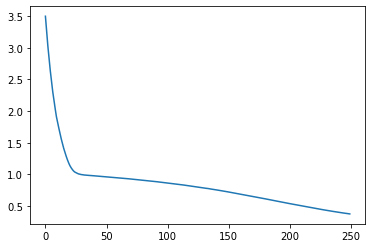

In [6]:
# Loss history
plt.plot(lossHistory.history['loss'])

In [7]:
# Make predictions
Y_hat = model.predict(X)

# Evaluate model
from sklearn.metrics import classification_report
print(classification_report(np.argmax(Y, axis=-1), np.argmax(Y_hat, axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.91      0.86      0.89        50
           2       0.87      0.92      0.89        50

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



We can see that the model performance is very good after 250 epochs, with accuracy at 93% and F1-scores around 0.89-1.0.

### Model (Snapshot Ensemble)

Now we will demonstrate how to use `snapshot_ensemble` to generate an ensemble of trained DNNs at the cost of a single training period. The DNN will be trained with cosine annealing, and here we just use the default hyperparameters which we can visualize below:

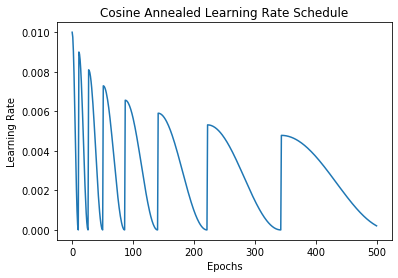

In [8]:
from snapshot_ensemble import *
VisualizeLR(cycle_length=10, cycle_length_multiplier=1.5, lr_multiplier=0.9, lr_init=0.01, lr_min=1e-6)

To do this, we simply pass in `SnapshotEnsembleCallback` into the `callbacks` argument when training. If validation data is supplied and we wished to also save the "best" model that minimizes validation loss, we may also use the helper function `GenerateSnapshotCallbacks()` that includes both `SnapshotEnsembleCallback` and `ModelCheckpoint`. By default, these models are saved into `Ensemble/` in the current working directory.

In [9]:
# Compile the DNN model
architecture = [6,6]
model = CompileDNNModel(numFeatures=numFeatures, numOutcomes=numOutcomes, architecture=architecture)

# Snapshot Ensemble callbacks
callbacks = [
    # Note: See `help(SnapshotEnsembleCallback)` for documentation on the hyperparameters
    SnapshotEnsembleCallback(cycle_length=10, cycle_length_multiplier=1.5, lr_multiplier=0.9, lr_init=0.01, lr_min=1e-6),   
]

# Train the model with cosine annealing + snapshot ensemble
lossHistory = model.fit(X, Y, 
                        batch_size=50,
                        epochs=250,
                        callbacks=callbacks,
                        shuffle=True,
                        verbose=0
                       )

Saving ensembled models to Ensemble/.


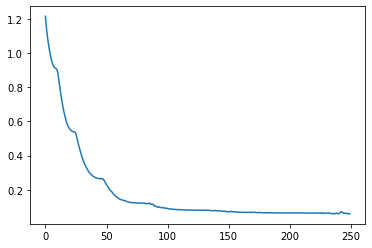

In [10]:
# Loss history
plt.plot(lossHistory.history['loss'])

After training, we will load the saved models from `Ensemble/` to be used as part of an ensemble. For simplicity, we will use uniform weights and average each model's estimates.

In [11]:
# Load in snapshotted models as an ensemble
import glob
models = []
for file in glob.glob('Ensemble/*.h5'):
    mod = CompileDNNModel(numFeatures=numFeatures, numOutcomes=numOutcomes, architecture=architecture)
    mod.load_weights( file )
    models.append( mod )

In [12]:
# Make ensembled predictions
Y_hat_ens = []
for mod in models:
    Y_hat_k = mod.predict( X )
    Y_hat_ens.append( Y_hat_k )

# Ensemble with simple uniform weights
Y_hat_ens = np.mean(Y_hat_ens, axis=0)

In [13]:
# Evaluate model
print(classification_report(np.argmax(Y, axis=-1), np.argmax(Y_hat_ens, axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.94      0.97        50
           2       0.94      1.00      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150



We can see that accuracy has improved to 98% as well as the F1-scores to 0.97-1.0. Note that the hyperparameters of the learning rate schedule can be important and the default values are likely suboptimal for your task - they will require some hyperparameter tuning and understanding of the loss surface.